In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
mnist = tf.keras.datasets.mnist # 이미지 하나 당 18.4메가바이트

In [ ]:
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
x_train = x_train / 127.5 - 1

In [ ]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [ ]:
encoder_input = tf.keras.Input(shape=(28, 28, 1))

# 28 X 28
x = Conv2D(32, 3, padding='same')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 28 X 28 -> 14 X 14
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 14 X 14 -> 7 X 7
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 7 X 7
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

# 2D 좌표로 표기하기 위하여 2를 출력값으로 지정합니다.
encoder_output = Dense(2)(x)

In [ ]:
encoder = Model(encoder_input, encoder_output)

In [ ]:
encoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_30 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                         

In [ ]:
# Input으로는 2D 좌표가 들어갑니다.
decoder_input = tf.keras.Input(shape=(2, ))

# 2D 좌표를 7*7*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(7*7*64)(decoder_input)
x = Reshape( (7, 7, 64))(x)

# 7 X 7 -> 7 X 7
x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 7 X 7 -> 14 X 14
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 14 X 14 -> 28 X 28
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 28 X 28 -> 28 X 28
x = Conv2DTranspose(32, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh')(x)

In [ ]:
decoder = Model(decoder_input, decoder_output)

In [ ]:
decoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 7, 7, 64)         36928     
 Transpose)                                                      
                                                                 
 batch_normalization_33 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 7, 7, 64)          0  

In [ ]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

In [ ]:
encoder_in = tf.keras.Input(shape=(28, 28, 1))
x = encoder(encoder_in)
decoder_out = decoder(x)

In [ ]:
auto_encoder = Model(encoder_in, decoder_out)

In [ ]:
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=tf.keras.losses.MeanSquaredError())

In [ ]:
checkpoint_path = 'tmp/01-basic-auto-encoder-MNIST.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='loss',
                             verbose=1)

In [ ]:
auto_encoder.fit(x_train, x_train,
                 batch_size=BATCH_SIZE,
                 epochs=5,
                 callbacks=[checkpoint],
                )

Epoch 1/5
1875/1875 [==============================] - ETA: 0s - loss: 0.2077
Epoch 1: loss improved from inf to 0.20767, saving model to tmp/01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 511s 271ms/step - loss: 0.2077
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - loss: 0.1843
Epoch 2: loss improved from 0.20767 to 0.18432, saving model to tmp/01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 479s 256ms/step - loss: 0.1843
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - loss: 0.1783
Epoch 3: loss improved from 0.18432 to 0.17833, saving model to tmp/01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 467s 249ms/step - loss: 0.1783
Epoch 4/5
1875/1875 [==============================] - ETA: 0s - loss: 0.1746
Epoch 4: loss improved from 0.17833 to 0.17455, saving model to tmp/01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 459s 245ms/step

In [ ]:
auto_encoder.load_weights(checkpoint_path)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
xy = encoder.predict(x_train)

1875/1875 [==============================] - 39s 20ms/step


In [ ]:
xy.shape, y_train.shape

((60000, 2), (60000,))

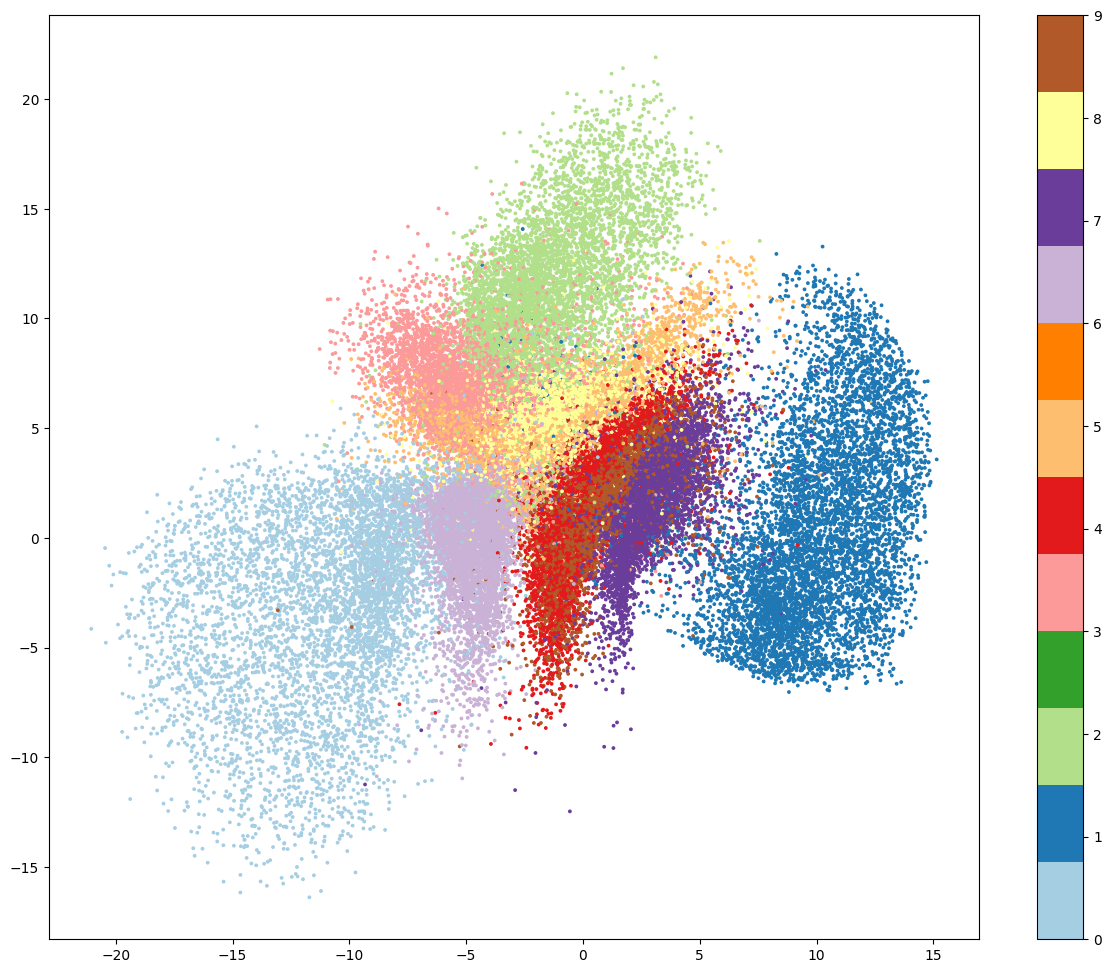

In [ ]:
plt.figure(figsize=(15, 12))
plt.scatter(x=xy[:, 0], y=xy[:, 1], c=y_train, cmap=plt.get_cmap('Paired'), s=3)
plt.colorbar()
plt.show()

In [ ]:
decoded_images = auto_encoder.predict(x_train)

1875/1875 [==============================] - 169s 90ms/step


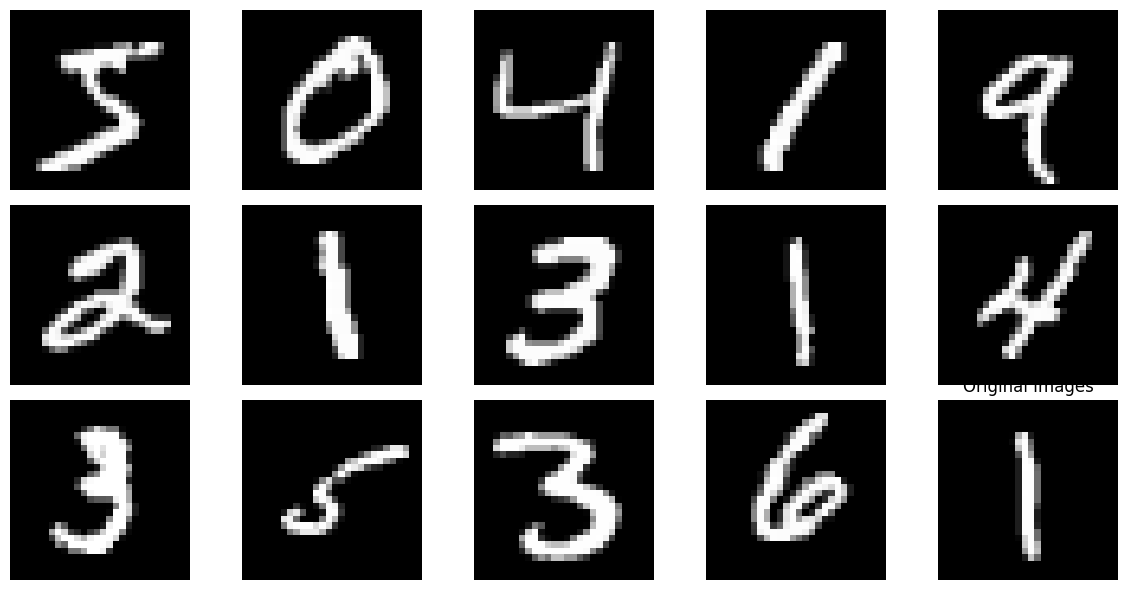

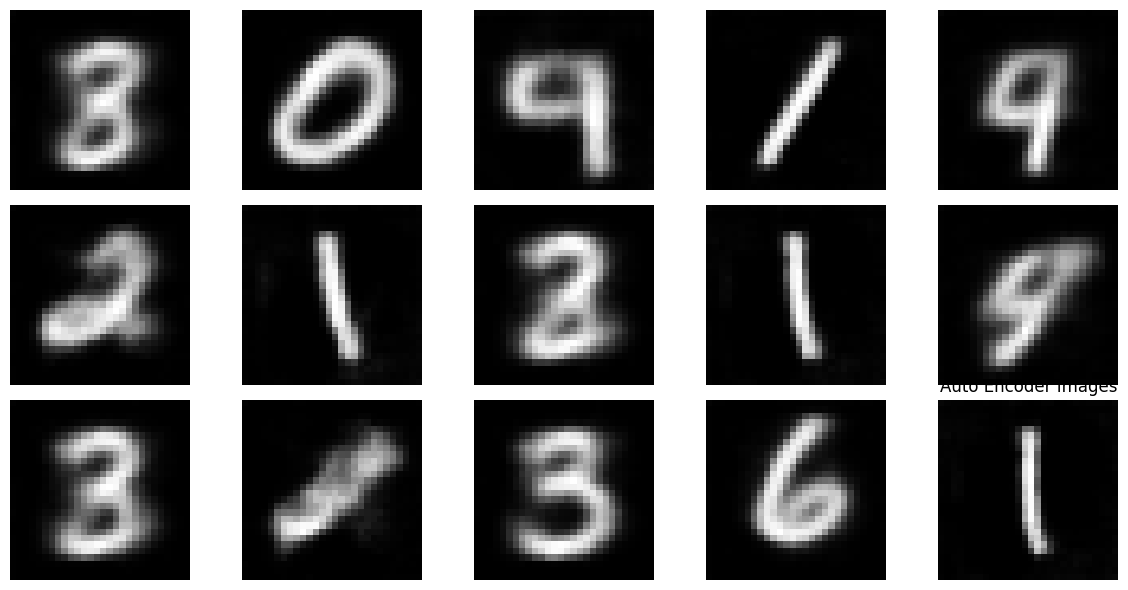

In [ ]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Original Images')
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Auto Encoder Images')
plt.show()